In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix,auc
import cv2

In [3]:
data=pd.read_csv("fer2013.csv")

data.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [5]:
data=data.drop('Usage',axis=1)

In [6]:
data.shape

(35887, 2)

In [7]:
data["emotion"].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [8]:
data.isna()

,emotion,pixels
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
35882,False,False
35883,False,False
35884,False,False
35885,False,False


In [9]:
data['pixels'] = data['pixels'].apply(lambda x: x.reshape(48, 48, 1) if isinstance(x, np.ndarray) else np.array(x.split(), dtype='float32').reshape(48, 48, 1))

In [10]:
x = np.array([pixels for pixels in data['pixels']])

In [11]:
x.dtype

dtype('float32')

In [12]:
x.shape

(35887, 48, 48, 1)

In [13]:
y = data['emotion'].values

In [14]:
y

array([0, 0, 2, ..., 0, 3, 2], dtype=int64)

In [15]:
x=x/255.0

In [16]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

datagen.fit(x)


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam

model = Sequential()

# First Convolutional Block
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second Convolutional Block
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Third Convolutional Block
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))  # 7 output classes




In [24]:
from tensorflow.keras.metrics import Precision, Recall, AUC

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc', multi_label=True)
    ]
)


In [25]:
from sklearn.model_selection import train_test_split

In [26]:
# Set parameters
batch_size = 64
epochs = 50

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [27]:

from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train, num_classes=7)
y_val_cat = to_categorical(y_val, num_classes=7)

In [28]:
# Create training data generator
train_generator = datagen.flow(x_train, y_train_cat, batch_size=batch_size)

# Train model
history = model.fit(train_generator, epochs=epochs, validation_data=(x_val, y_val_cat))

Epoch 1/50
449/449 [==============================] - 25s 50ms/step - loss: 2.2338 - accuracy: 0.2103 - precision: 0.2261 - recall: 0.0812 - auc: 0.5394 - val_loss: 1.9932 - val_accuracy: 0.2547 - val_precision: 0.1923 - val_recall: 6.9657e-04 - val_auc: 0.5880
Epoch 2/50
449/449 [==============================] - 21s 47ms/step - loss: 2.0646 - accuracy: 0.2217 - precision: 0.2526 - recall: 0.0660 - auc: 0.5537 - val_loss: 1.7696 - val_accuracy: 0.2795 - val_precision: 0.4708 - val_recall: 0.0426 - val_auc: 0.6323
Epoch 3/50
449/449 [==============================] - 21s 47ms/step - loss: 1.9847 - accuracy: 0.2345 - precision: 0.2782 - recall: 0.0573 - auc: 0.5623 - val_loss: 1.7547 - val_accuracy: 0.3125 - val_precision: 0.6210 - val_recall: 0.0189 - val_auc: 0.6438
Epoch 4/50
449/449 [==============================] - 21s 47ms/step - loss: 1.9326 - accuracy: 0.2399 - precision: 0.3056 - recall: 0.0524 - auc: 0.5744 - val_loss: 1.6977 - val_accuracy: 0.3128 - val_precision: 0.6101 - v

225/225 [==============================] - 1s 6ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.40      0.47       985
           1       0.70      0.07      0.13       102
           2       0.68      0.11      0.19      1043
           3       0.66      0.88      0.76      1765
           4       0.49      0.31      0.38      1210
           5       0.69      0.73      0.71       795
           6       0.41      0.76      0.53      1278

    accuracy                           0.56      7178
   macro avg       0.60      0.47      0.45      7178
weighted avg       0.58      0.56      0.52      7178



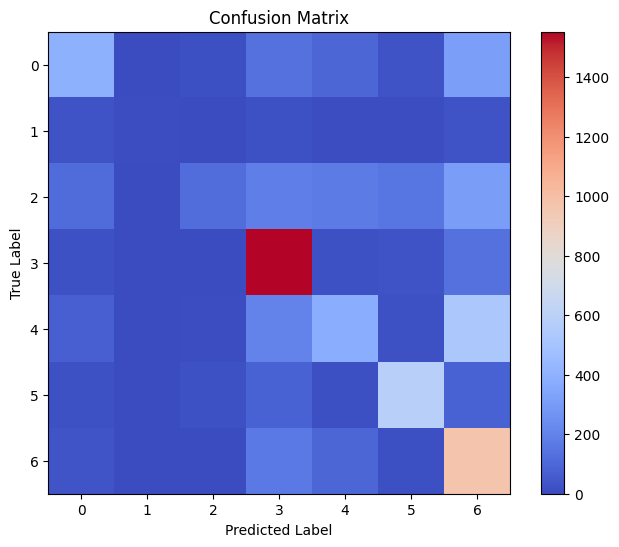

In [42]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Predictions
y_pred = np.argmax(model.predict(x_val), axis=1)

# Convert one-hot to class indices
y_true = y_val

# Classification report
report = classification_report(y_true, y_pred)
print("Classification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='coolwarm')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.colorbar()
plt.show()
